In [3]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np
import cv2
import pandas as pd
from keras.models import model_from_json, load_model
import json

Using TensorFlow backend.


モデルの読み込み準備

In [4]:
# リサイズ後の画像サイズ
rheight = 672//4
rwidth = 512//4 

img_shape = (rheight, rwidth, 1)
batch_size = 16
latent_dim = 2  # Dimensionality of the latent space: a plane

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])
# This is the input where we will feed `z`.
decoder_input = layers.Input(K.int_shape(z)[1:])

# Upsample to the correct number of units
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# Reshape into an image of the same shape as before our last `Flatten` layer
x = layers.Reshape(shape_before_flattening[1:])(x)

# We then apply then reverse operation to the initial
# stack of convolution layers: a `Conv2DTranspose` layers
# with corresponding parameters.
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)
# We end up with a feature map of the same size as the original input.

# This is our decoder model.
decoder = Model(decoder_input, x)

# We then apply it to `z` to recover the decoded `z`.
z_decoded = decoder(z)
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

# We call our custom layer on the input and the decoded output,
# to obtain the final model output.
y = CustomVariationalLayer()([input_img, z_decoded])

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

# 定義
json_file = open('vae.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json, custom_objects={
    'CustomVariationalLayer': CustomVariationalLayer,
    'latent_dim' : latent_dim,
    'z_log_var' : z_log_var,})

# weights
loaded_model.load_weights('ae_mnist_weights.h5')






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 168, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 168, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 84, 64, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 84, 64, 64)   36928       conv2d_2[0][0]                   
_________

モデル読み込み

In [5]:
loaded_model

中間層モデルの構築

In [4]:
middle_model = Model(inputs=loaded_model.input, outputs=loaded_model.get_layer('lambda_1').output)

画像の読み込み

In [59]:
# 画像サイズ
height = 672
width = 512
# 訓練データの配列化
cloud_train_path_df = pd.read_csv('../data/external/train_img_path_info.csv')
cloud_train_list= []
for i in range(cloud_train_path_df.shape[0]):
    cloud_train_img = cv2.imread('.'+cloud_train_path_df['img_path'][i], 0)
    resize = 4
    desired_im_sz = (512//resize, 672//resize)  # ( height , width )
    cloud_train_img = cv2.resize(cloud_train_img, dsize=desired_im_sz, interpolation=cv2.INTER_CUBIC)
    cloud_train_list.append(cloud_train_img)
cloud_trains = np.array(cloud_train_list)
# テストデータの配列化
cloud_test_path_df = pd.read_csv('../data/external/test_img_path_info.csv')
cloud_test_list= []
for i in range(cloud_test_path_df.shape[0]):
    cloud_test_img = cv2.imread('.'+cloud_test_path_df['img_path'][i], 0)
    resize = 4
    desired_im_sz = (512//resize, 672//resize)  # ( height , width )
    cloud_test_img = cv2.resize(cloud_test_img, dsize=desired_im_sz, interpolation=cv2.INTER_CUBIC)
    cloud_test_list.append(cloud_test_img)
cloud_tests = np.array(cloud_test_list)

潜在変数と入力画像の時刻をテーブル化

In [221]:
cloud_train_path_df = pd.read_csv('../data/external/train_img_path_info.csv')

# i = 0 #range(cloud_train_path_df.shape[0])

z_list = []
date_list = []
for i in range(cloud_trains.shape[0]):
    img = cloud_trains[i].reshape(1,168,128,1)
    z_arr = middle_model.predict(img).reshape(2)
    z_list.append(z_arr)

    year = int(cloud_train_path_df['img_file_name'][i][0:4])
    month = int(cloud_train_path_df['img_file_name'][i][5:7])
    day = int(cloud_train_path_df['img_file_name'][i][8:10])
    hour = int(cloud_train_path_df['img_file_name'][i][11:13])
    date_arr = np.array([year, month, day, hour])
    date_list.append(date_arr)

z_df = pd.DataFrame(z_list, columns=['z1','z2'])
date_df = pd.DataFrame(date_list, columns=['y','m','d','h'])
train_df = pd.concat([date_df, z_df], axis=1)

# cloud_train_path_df['img_file_name'][i], date_list, z_list, date_df, z_df, df
train_df

,y,m,d,h,z1,z2
0,2016,1,1,1,0.696134,-0.289184
1,2016,1,1,2,0.528576,0.812040
2,2016,1,1,3,-0.919482,-1.076477
3,2016,1,1,4,-0.890272,-0.002467
4,2016,1,1,5,-1.099972,-0.331108
5,2016,1,1,6,-1.339835,1.005835
6,2016,1,1,7,-0.942384,-0.650839
7,2016,1,1,8,-1.802404,0.003591
8,2016,1,1,9,0.474538,0.903757
9,2016,1,1,10,-0.276067,1.420350


k-means でクラスタリング

In [223]:
from sklearn.cluster import KMeans

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

vec_df = train_df[['z1', 'z2']]

train_df['cluster'] = kmeans.fit(vec_df).labels_

季節のラベリング

In [244]:
lst = []
for rcd in train_df['m']:
    if 1<=rcd<=2 or rcd==12:
        lst.append(0)
    elif 3<=rcd<=5:
        lst.append(1)
    elif 6<=rcd<=8:
        lst.append(2)
    elif 9<=rcd<=11:
        lst.append(3)
        
train_df['season'] = lst

k-means 描画

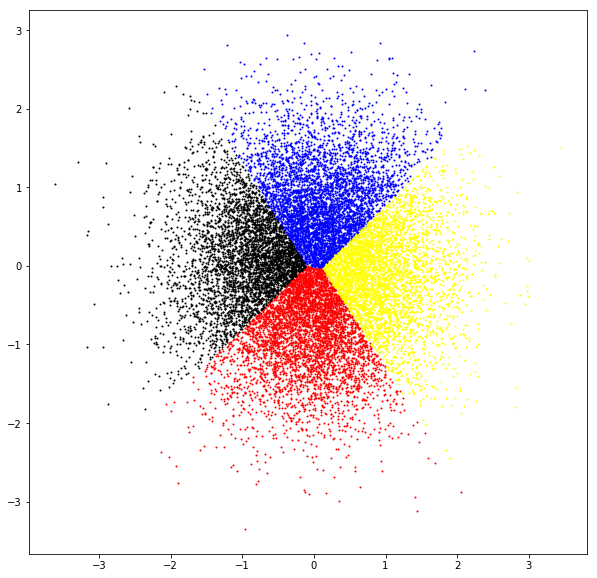

In [257]:
red = train_df[(train_df[u'cluster']==0)]
blue = train_df[(train_df[u'cluster']==1)]
black = train_df[(train_df[u'cluster']==2)]
yellow = train_df[(train_df[u'cluster']==3)]

plt.figure(figsize=(10,10))
plt.scatter(red['z1'], red['z2'], s=1, c='red')
plt.scatter(blue['z1'], blue['z2'], s=1, c='blue')
plt.scatter(black['z1'], black['z2'], s=1, c='black')
plt.scatter(yellow['z1'], yellow['z2'], s=1, c='yellow')

季節描画

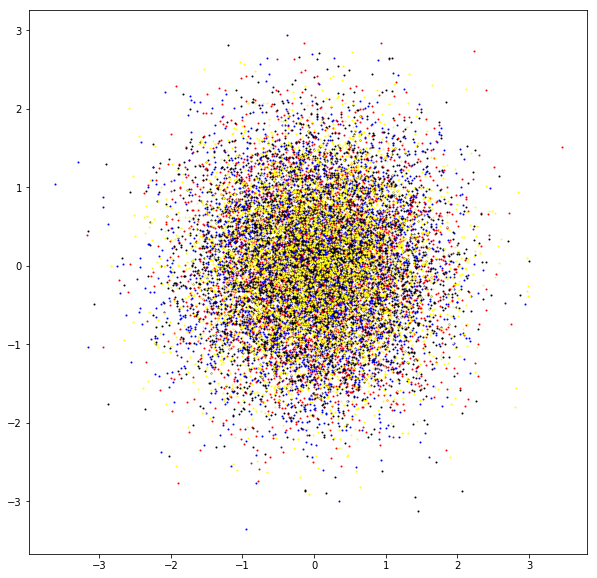

In [256]:
winter = train_df[(train_df[u'season']==0)]
spring = train_df[(train_df[u'season']==1)]
summer = train_df[(train_df[u'season']==2)]
autumn = train_df[(train_df[u'season']==3)]

plt.figure(figsize=(10,10))
plt.scatter(winter['z1'], winter['z2'], s=1, c='red')
plt.scatter(spring['z1'], spring['z2'], s=1, c='blue')
plt.scatter(summer['z1'], summer['z2'], s=1, c='black')
plt.scatter(autumn['z1'], autumn['z2'], s=1, c='yellow')